<a href="https://colab.research.google.com/github/gulabpatel/Code-Mixing/blob/main/01_Code_Mixing_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Studying CSS patterns of Indian Speakers in Code-Mixed Tweets

In this notebook, we will learn one of the most useful ways of processing Code-Mixed text from twitter (by utilizing word-level language identification), and then analyze initial patterns in the data that consists of tweets from/about Indian speakers.

 Code walkthrugh video : https://huggingface.co/docs/transformers/model_doc/m2m_100

### Downloading and Preparing Data

#### 1. About Data

- We are using a custom dataset that was created for this class specifically. It has 510 tweets from/about Indian speakers.
- We have sampled some code-mixed English-Hindi tweets in roman script from [Silent Flame's NER Code-Mixed Corpus](https://github.com/SilentFlame/Named-Entity-Recognition).
- We have extracted tweets related to the query `india` from Twitter, using [twitter's developer API](https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction).

In [1]:
!wget https://raw.githubusercontent.com/mohdsanadzakirizvi/plaksha_rasa/main/assignments/plaksha_tweet_data_1.csv

--2022-08-10 07:22:33--  https://raw.githubusercontent.com/mohdsanadzakirizvi/plaksha_rasa/main/assignments/plaksha_tweet_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67390 (66K) [text/plain]
Saving to: ‘plaksha_tweet_data_1.csv’

plaksha_tweet_data_ 100%[===================>]  65.81K  --.-KB/s    in 0.001s  

2022-08-10 07:22:33 (53.9 MB/s) - ‘plaksha_tweet_data_1.csv’ saved [67390/67390]



#### 2. Exploring the Data

In [2]:
# read data
import pandas as pd

tweetdf = pd.read_csv('plaksha_tweet_data_1.csv')
tweetdf

,Tweet
0,RT @RavinderKapur2: Narendra Modi and Devendra...
1,RT @MahuaMoitra: It is perhaps India’s greates...
2,RT @ActualidadRT: Pakistán e India ignoran a W...
3,@kimpaim A Índia de Taubaté é a que estava no...
4,RT @Zee_Hindustan: Shehnaaz Gill ने 2019 में ह...
...,...
506,RT @ZEE5India: We couldn’t find a better way t...
507,"Yeduurappa is honest, Jay Shah is honest, Mopa..."
508,election agenda toh #RamMandir hai kabse bol r...
509,Bengal Arson: 2 Kids Among 8 Killed in Birbhum...


We notice that there are certain inconsistencies in the raw tweets, let's do a basic round of preprocessing to fix that. We will normalize the text by first converting everything to lower case and then removing URLs and non-alphabetic characters.

In [3]:
import re

def text_cleaner(text):
    #converting to lowercase
    newString = text.lower()
    #removing links
    newString = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', newString) 
    #fetching alphabetic characters
    newString = re.sub('[^a-zA-Z#@]', ' ', newString)
    return newString

In [4]:
tweetdf['cleaned_text'] = tweetdf['Tweet'].apply(text_cleaner)

tweetdf.head()

,Tweet,cleaned_text
0,RT @RavinderKapur2: Narendra Modi and Devendra...,rt @ravinderkapur narendra modi and devendra...
1,RT @MahuaMoitra: It is perhaps India’s greates...,rt @mahuamoitra it is perhaps india s greates...
2,RT @ActualidadRT: Pakistán e India ignoran a W...,rt @actualidadrt pakist n e india ignoran a w...
3,@kimpaim A Índia de Taubaté é a que estava no...,@kimpaim a ndia de taubat a que estava no...
4,RT @Zee_Hindustan: Shehnaaz Gill ने 2019 में ह...,rt @zee hindustan shehnaaz gill ...


Now that we've cleaned the tweets, let's build a word cloud and see what kind of word frequency distribution we have in the underlying data.

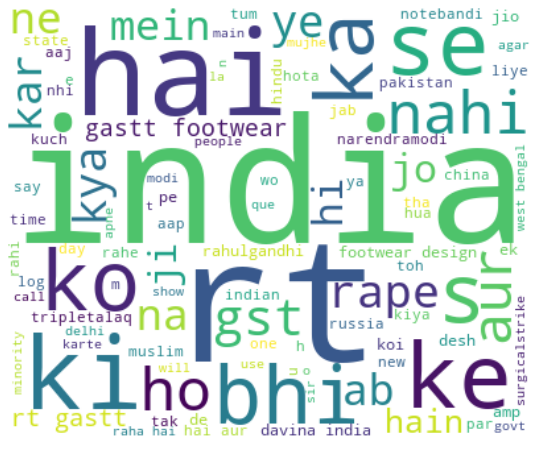

In [5]:
#Import libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
total_text = " ".join(tweetdf.cleaned_text.tolist())
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_text(total_text)
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The above visualization gives a rudimentary overview of topic/word distribution in the data. We can see some of the topics that are recurring in the data. We also notice that lot of high-frequency words are code-mixed words from Hindi written in roman script.

### Installing LID-tool



#### About LID-tool 

- It is a word level language identification tool for identifying Code-Mixed text of languages (like Hindi etc.) written in roman script and mixed with English.

- At a broader level, we utilize a ML classifier that's trained using [MALLET](https://mimno.github.io/Mallet/index) to generate word level probabilities for language tags. We then utilize these probabilities along with the context information of surrounding words to generate language tags for each word of the input. 

- We also use hand-crafted dictionaries as look-up tables to cover unique, corner and conflicting cases to give a robust language identification tool. 

- Note: LID is shorthand for [Language Identification](https://en.wikipedia.org/wiki/Language_identification).

Now that we've learned about the tool, let's install it!


In [6]:
!git clone https://github.com/microsoft/LID-tool.git

Cloning into 'LID-tool'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 54 (delta 6), reused 39 (delta 2), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [7]:
!ls LID-tool/

classifiers	    getLanguage.py  sampleinp.txt	  tests
CODE_OF_CONDUCT.md  images	    sampleinp.txt_tagged  tmp
config.ini	    LICENSE	    sampleoutp.txt	  Train_Custom_LID.md
dictionaries	    README.md	    SECURITY.md		  utils


In [8]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-08-10 07:22:35--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-08-10 07:22:35--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  59.0MB/s    in 0.3s    

2022-08-10 07:22:35 (59.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [9]:
!pip install twitter-text-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for twitter-text-python: filename=twitter_text_python-1.1.1-py3-none-any.whl size=10038 sha256=bb1e9707586d2da5878d381a370fd09166984626f09f2bd75ad50aa8d4707ecb
  Stored in directory: /root/.cache/pip/wheels/b9/da/73/f52b2caab4e30520ebefdc029b00cffb1901cc02a7cdad2db3
Successfully built twitter-text-python


In [10]:
!mkdir LID-tool/mallet-2.0.8
!cp -r mallet-2.0.8 LID-tool/

In [11]:
%cd LID-tool/

/content/LID-tool


In [12]:
!mv dictionaries/dict1hi.txt dictionaries/dicthi.txt
!touch dictionaries/dict1hi.txt

!mv dictionaries/dict1hinmov.txt dictionaries/dicthinmov.txt
!touch dictionaries/dict1hinmov.txt

If you've run all the above cells without an error then your setup of LID-tool is complete!

### Running LID on the Tweets

Now that we have installed LID-tool, let's run it on a bunch of sample sentences that are given in the tool. The following are the sentences we want to be language tagged:

In [13]:
!cat sampleinp.txt

1	Yeh mera pehla sentence hai
2	Aur ye dusra
3	Main kya karoon
4	This is main sentence

#### 1. Initial run on sample tweets



In [14]:
!rm sampleinp.txt_tagged

In [15]:
!python getLanguage.py sampleinp.txt

HINDI dictionary created
ENGLISH dictionary created
sampleinp.txt
['getLanguage.py', 'sampleinp.txt']
time for mallet classification 1.7504160404205322
Yeh	en	0.3590321271096717	hi	0.6409678728903284
mera	en	0.012166092658460071	hi	0.98783390734154
pehla	en	3.3597386600962424E-4	hi	0.9996640261339904
sentence	en	0.999999999	hi	1e-09
hai	en	0.999999999	hi	1e-09 
---------------------------------

time for mallet classification 1.2779970169067383
Aur	en	0.832483388331911	hi	0.16751661166808904
ye	en	0.999999999	hi	1e-09
dusra	en	0.009362950333435751	hi	0.9906370496665643 
---------------------------------

time for mallet classification 1.2611382007598877
Main	en	0.999999999	hi	1e-09
kya	en	0.999999999	hi	1e-09
karoon	en	0.004832763543168134	hi	0.9951672364568319 
---------------------------------

time for mallet classification 1.5319948196411133
This	en	0.999999999	hi	1e-09
is	en	0.999999999	hi	1e-09
main	en	0.999999999	hi	1e-09
sentence	en	0.999999999	hi	1e-09 
-----------------------

Notice that in the third sentence, the words `main` and `kya` have high English probabilities even though they are actually Hindi words in that sentence's context. While the same word `main` is actually an English word in the context of fourth sentence and accordingly has high English probabilities.

Let's see what this means for out final language tag output:

In [16]:
!cat sampleinp.txt_tagged

##1	Yeh mera pehla sentence hai
1	Yeh/HI mera/HI pehla/HI sentence/EN hai/EN 
##2	Aur ye dusra
2	Aur/EN ye/EN dusra/HI 
##3	Main kya karoon
3	Main/EN kya/EN karoon/HI 
##4	This is main sentence
4	This/EN is/EN main/EN sentence/EN 


As we can see, the LID-tool has performed well by tagging `main` in th fourth sentence as EN. But, it has mistaked the words `main` and `kya` as EN in the third sentence. 

All is not bad though, since it has correctly predicted the word `karoon` as HI in the third sentence with high probability.

Let's see how we can improve the above output by utilizing the concept of dictionaries.

#### 2. Improving the output by utilizing dictionaries

The LID-tool has two major components: an ML model trained on n-gram features and a couple of word lists (dictionaries) in both the languages. 

![](https://raw.githubusercontent.com/microsoft/LID-tool/main/images/info_flow_new_lid.PNG)



Now let's make slight change in our dictionaries. Go to `LID-tool/dictionaries/dict1hinmov.txt` file and the words "kya" and "main" in separate lines one at a time. Then let's rerun the pipeline and check what changes.

In [17]:
!rm sampleinp.txt_tagged
!rm dictionaries/memoize_dict.pkl

In [18]:
!python getLanguage.py sampleinp.txt

HINDI dictionary created
ENGLISH dictionary created
sampleinp.txt
['getLanguage.py', 'sampleinp.txt']
time for mallet classification 1.5303964614868164
Yeh	en	0.3590321271096717	hi	0.6409678728903284
mera	en	0.012166092658460071	hi	0.98783390734154
pehla	en	3.3597386600962424E-4	hi	0.9996640261339904
sentence	en	0.999999999	hi	1e-09
hai	en	0.999999999	hi	1e-09 
---------------------------------

time for mallet classification 1.182682991027832
Aur	en	0.832483388331911	hi	0.16751661166808904
ye	en	0.999999999	hi	1e-09
dusra	en	0.009362950333435751	hi	0.9906370496665643 
---------------------------------

time for mallet classification 1.1295812129974365
Main	en	0.999999999	hi	1e-09
kya	en	0.999999999	hi	1e-09
karoon	en	0.004832763543168134	hi	0.9951672364568319 
---------------------------------

time for mallet classification 1.0733158588409424
This	en	0.999999999	hi	1e-09
is	en	0.999999999	hi	1e-09
main	en	0.999999999	hi	1e-09
sentence	en	0.999999999	hi	1e-09 
------------------------

In [19]:
!cat sampleinp.txt_tagged

##1	Yeh mera pehla sentence hai
1	Yeh/HI mera/HI pehla/HI sentence/EN hai/EN 
##2	Aur ye dusra
2	Aur/EN ye/EN dusra/HI 
##3	Main kya karoon
3	Main/EN kya/EN karoon/HI 
##4	This is main sentence
4	This/EN is/EN main/EN sentence/EN 


The addition of dictionaries in the project was an engineering decision that was taken after considering the empirical results, which showed that the dictionaries complemented the performance of the ML-based classifier (MALLET) for certain corner-cases. 

Here are some of the problems that this method solved:

**1.Dealing with “common words” that can belong to either of the languages.**

For example, the English word `“to”` is one of the ways in which the Hindi word `“तो”` or `“तू”` is spelt when written in `roman script` so the word “to” will be classified differently in the following two sentences:


**Input:**       I have to get back to my advisor

**Output:**    I/EN have/EN ***to/EN*** get/EN back/EN to/EN my/EN advisor/EN 

**Input:**       Bhai to kabhi nahi sudhrega

**Output:**    Bhai/HI ***to/HI*** kabhi/HI nahi/HI sudhrega/HI


In this case, we make sure that the word “to” is present in both the dictionaries and the LID is supposed to focus more on the combination of ML probabilities and Context (surrounding words) to tag the language. For instance, the probability values "1e-09" and "0.999999999" indicate the word is present in dictionary(s).

**2.Words that surely belong to only one language.** 

For example, words like “bhai”, “nahi”, “kabhi” in Hindi and words like “advisor”, “get” etc. in English. In this case, we utilize the relevant dictionary to force tag it to the correct language even if the ML classifier says otherwise.

So the questions that you have to ask yourself while creating the dictionaries are: 

1. “Are there certain words that can be spelt the same way in both the languages?” And, 
2. “Are there common words in one language that surely can’t be used in the other language?”

These are just a couple of things that we looked at while building this tool, but given your specific use-case you can consider more such engineering use-cases and customize the dictionaries accordingly. 

- [Implementation in Code](https://github.com/microsoft/LID-tool/blob/f6528ebd8ac77b561f10d3659799f3f8894deb09/getLanguage.py#L147)
- [More details in Docs](https://github.com/microsoft/LID-tool/blob/main/Train_Custom_LID.md)

### Analyzing Code-Mixing Patterns in Tweets

#### Getting Language Tagged Tweets

Due to the limitations of free version of Colab and in the interest of time, we have already computed language tags for all the tweets in the dataset. Let's fetch them!

In [20]:
!wget https://raw.githubusercontent.com/mohdsanadzakirizvi/plaksha_rasa/main/assignments/tagged_tweets.txt

--2022-08-10 07:22:58--  https://raw.githubusercontent.com/mohdsanadzakirizvi/plaksha_rasa/main/assignments/tagged_tweets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140771 (137K) [text/plain]
Saving to: ‘tagged_tweets.txt’

tagged_tweets.txt   100%[===================>] 137.47K  --.-KB/s    in 0.003s  

2022-08-10 07:22:58 (47.5 MB/s) - ‘tagged_tweets.txt’ saved [140771/140771]



In [21]:
with open('tagged_tweets.txt') as fp:
  tagged_tweets = fp.readlines()

tagged_tweets[:5]

['##1\trt @tathagata   welcome to the most cultured state in india which gave birth to raja ram mohun roy vidyasagar  swami vivekananda  tagore an\n',
 '1\trt/EN @tathagata/OTHER welcome/EN to/EN the/EN most/EN cultured/EN state/EN in/EN india/EN which/EN gave/EN birth/EN to/EN raja/HI ram/HI mohun/HI roy/HI vidyasagar/HI swami/HI vivekananda/HI tagore/HI an/EN \n',
 '##2\t#antimuslimwomencong ye  sahi h #naishhaasan ji aap ne #tripletalaq ko khatm krne ke liye  ladai ki ab jab khatm kr dia toh ab  keha rahi ho ki faida bhi do #naishhaasan ab  kya tum #politician banna  chahati ho kya   apni raajniti me aane ki roti sakne ke lite aag laga rahi ho\n',
 '2\t#antimuslimwomencong/OTHER ye/EN sahi/HI h/HI #naishhaasan/OTHER ji/HI aap/HI ne/EN #tripletalaq/OTHER ko/HI khatm/HI krne/HI ke/HI liye/HI ladai/HI ki/HI ab/EN jab/HI khatm/HI kr/HI dia/HI toh/HI ab/EN keha/HI rahi/HI ho/EN ki/HI faida/HI bhi/HI do/EN #naishhaasan/OTHER ab/EN kya/HI tum/HI #politician/OTHER banna/HI chahati/HI ho/EN 

In [22]:
len(tagged_tweets)

966

#### 1. Basic aggregation metrics

Let's find out the number of tweets in each of the categories: Mostly En, Mostly Hi and Code-Mixed. We will also cluster the tweets later based on it.

In [23]:
# threshold of 70% of total word length
thres = 0.7

outdf = []

# aggregate word frequencies
for twt in tagged_tweets:
  en_fr, hi_fr = 0, 0
  if not twt.startswith('##'):
    tags = twt.split()
    taglen = len(tags)
    for t in tags:
      if 'HI' in t:
        hi_fr += 1
      if 'EN' in t:
        en_fr += 1
    
    if hi_fr/taglen >= thres:
      outdf.append((twt, 0, 1, 0))
    elif en_fr/taglen >= thres:
      outdf.append((twt, 1, 0, 0))
    else:
      outdf.append((twt, 0, 0, 1))

# create the output dataframe
outdf = pd.DataFrame(outdf, columns = ['Tweet', 'EN', 'HI', 'CM'])
outdf.head()

,Tweet,EN,HI,CM
0,1\trt/EN @tathagata/OTHER welcome/EN to/EN the...,0,0,1
1,2\t#antimuslimwomencong/OTHER ye/EN sahi/HI h/...,0,0,1
2,3\trt/EN @adgpi/OTHER a/EN nine/EN officer/EN ...,1,0,0
3,4\trt/EN @ani/OTHER west/EN bengal/EN sit/EN i...,1,0,0
4,5\trt/EN @hate/OTHER stopper/EN jack/EN uppal/...,1,0,0


So now we have tagged each tweet based on whether it has mostly EN, HI or Code-Mixed words. 

**P.S.** You can play with the threshold value `thresh` given above and see how things change. Go crazy!

Let's now aggregate how many tweets fall in each category!

In [24]:
outdf.sum()

Tweet    1\trt/EN @tathagata/OTHER welcome/EN to/EN the...
EN                                                     199
HI                                                      53
CM                                                     231
dtype: object

Do you want to see tweets falling in a particular category? Just replace the 'CM' with the required tag in code in the following line:

In [25]:
outdf[outdf['EN'] == 1]

,Tweet,EN,HI,CM
2,3\trt/EN @adgpi/OTHER a/EN nine/EN officer/EN ...,1,0,0
3,4\trt/EN @ani/OTHER west/EN bengal/EN sit/EN i...,1,0,0
4,5\trt/EN @hate/OTHER stopper/EN jack/EN uppal/...,1,0,0
5,6\trt/EN @monica/OTHER america/EN @david/OTHER...,1,0,0
6,7\tsir/EN two/EN gang/EN rape/EN in/EN days/EN...,1,0,0
...,...,...,...,...
473,1\trt/EN @piyushgoyal/OTHER making/EN india/EN...,1,0,0
476,4\tscheduled/EN to/EN teach/EN my/EN first/EN ...,1,0,0
477,5\trt/EN @worcester/OTHER uni/EN graduate/EN a...,1,0,0
479,7\trt/EN @zee/OTHER india/EN we/EN couldn/EN t...,1,0,0


#### 2. Extracting user mentions and hashtags

We now have a general idea of the distribution of EN, HI and CM heavy tweets.
 Let's try to find some explaination of what might be the reason of tweets having the prominence of one of the above languages.

In order to do that, we can take advantage of one information that we have present in our tweets: hashtags (starting with `#` and user mentions (starting with `@`)

In [26]:
tagdf = []

# extract user mentions and tags
for twt in tagged_tweets:
  hashtags, users = [], []
  if not twt.startswith('##'):
    tags = twt.split()
    taglen = len(tags)
    for t in tags:
      if 'OTHER' in t:
        tok = t.split('/')[0]
        if t.startswith('@'):
          users.append(tok)
        if t.startswith('#'):
          hashtags.append(tok)
    tagdf.append((twt, hashtags, users))

# create the output dataframe
tagdf = pd.DataFrame(tagdf, columns = ['Tweet', 'Hashtags', 'Users'])
tagdf.head()

,Tweet,Hashtags,Users
0,1\trt/EN @tathagata/OTHER welcome/EN to/EN the...,[],[@tathagata]
1,2\t#antimuslimwomencong/OTHER ye/EN sahi/HI h/...,"[#antimuslimwomencong, #naishhaasan, #tripleta...",[]
2,3\trt/EN @adgpi/OTHER a/EN nine/EN officer/EN ...,"[#uaearmy, #india]",[@adgpi]
3,4\trt/EN @ani/OTHER west/EN bengal/EN sit/EN i...,[#birhum],[@ani]
4,5\trt/EN @hate/OTHER stopper/EN jack/EN uppal/...,[#thekashmirfiles],"[@hate, @royal, @phil]"


#### 3. Hypothesis

Now that we have tagged the tweets by both the prominent language and the hashtags + user mentions, let's merge the two dataframes and look at the bigger picture!

In [27]:
finaldf = outdf.merge(tagdf)

finaldf.sample(20)

,Tweet,EN,HI,CM,Hashtags,Users
335,2\t#rahulgandhi/OTHER ji/HI month/EN phele/HI ...,0,0,1,[#rahulgandhi],[]
320,7\ten/HI instagram/HI muy/EN #blacklivesmatter...,0,0,1,[#blacklivesmatter],[]
254,1\t@rmpars/OTHER is/EN a/EN fun/EN person/EN y...,1,0,0,[],[@rmpars]
501,5\t#barish/OTHER bhi/HI confused/EN hai/HI abh...,0,0,1,"[#barish, #gst]",[]
237,4\ttrue/EN shakal/HI nahin/HI milti/HI drama/H...,0,0,1,[],[]
21,1\t@naomi/OTHER i/EN don/EN t/EN understand/EN...,1,0,0,[],[@naomi]
239,6\tnd/EN one/EN more/EN thing/EN agar/HI koi/H...,0,0,1,[],[]
511,5\t#dhoni/OTHER captain/EN cool/EN ekdum/HI co...,0,0,1,"[#dhoni, #respect]",[]
329,6\tchitthi/HI bheji/HI thi/HI what/EN s/EN app...,0,0,1,[],[]
446,1\t@simplyarmaan/OTHER @talhahyunus/OTHER it/E...,1,0,0,[],"[@simplyarmaan, @talhahyunus]"


- On running the above script multiple times, we notice that there are patterns dictating when a tweet has Code-mixing vs. when it's just all English or all Hindi.

- One clear pattern is that the tweets that are from formal settings like those by news agencies or organisations (@reuters, @geologytime, @ani etc.) tend to use pure English in their tweets even when they are talking about incidents in India. It is true for even Indian news agencies.

- Conversely, we see lot of Code-Mixed words or majority of Hindi words in tweets that are by individual accounts. These are everyday folks just expressing their honest opinion on certain topics (having hashtags of major incidents in Indian society). Since, Code-mixing occurs naturally to them in their speech and day to day informal interactions, there's a tendency to do the same online. Which is interesting because they aren't just going for all Hindi words or even an all Hindi script but are heavily mixing both the script and words with Roman English.

- Another interesting pattern is that some organisations tend to use Code-Mixing when they are advertising a product or service (ex. @jio). Which is probably a marketing hack of making the customer feel "closer" to the product by speaking in "their colloquial language" which is usually full of Code-Mixing.

- The above set of early hypothesis corroborates with previous studies of Code-Mixing that it's a spoken language phenomenon that tends to happen more in informal contexts like speech, social media and chat apps like Whatsapp, Messenger etc.

- Please note that the above are but qualitative observations, we can perform more rigorous quantitative analyses to come up with solid conclusions from the data.

- Do you see any other patterns? Thoughts?

### Resources

You can refer the following resources for more details about the project:

- [GitHub Page](https://github.com/microsoft/LID-tool)
- [Papers](https://github.com/microsoft/LID-tool#papers)